In [7]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg', 'retina'}

import requests
import pandas as pd
import pandas.io.data as web
import numpy as np
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# set user agent & headers for crawling
user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) " + \
            "Chrome/37.0.2062.94 Safari/537.36"
headers = {"User-Agent": user_agent}

# Cwraling Kospi Companys
- the number of kospi companys
- kospi company list from stock naver api
- save kospi company list
- find company id from company name

In [4]:
# cwraling total count
def total_count():
    BASE_URL = "http://m.stock.naver.com/api/json/sise/siseListJson.nhn?\
                menu=market_sum&sosok=0&pageSize=1&page=1"
    response = requests.get(BASE_URL, headers=headers)
    return response.json()["result"]["totCnt"]

# function test code
totCnt = total_count()
totCnt

1197

In [5]:
# cwraling company list
def cwraling_company_list(totCnt):
    BASE_URL = "http://m.stock.naver.com/api/json/sise/siseListJson.nhn?menu=market_sum&sosok=0&pageSize=" + str(totCnt) + "&page=1"
                
    response = requests.get(BASE_URL, headers=headers)
    json_info = response.json()
    
    df = pd.DataFrame(columns=["company_id","company_name"])
    
    for i in range(0,totCnt):
        company_id = json_info["result"]["itemList"][i]["cd"]
        company_name = json_info["result"]["itemList"][i]["nm"]
        df.loc[len(df)] = {"company_id":company_id, "company_name":company_name}
        
    return df.fillna("")

# function test code
ccl = cwraling_company_list(totCnt)
ccl.head()

,company_id,company_name
0,005930,삼성전자
1,015760,한국전력
2,005380,현대차
3,012330,현대모비스
4,090430,아모레퍼시픽


In [6]:
# save kospi company list as csv file
ccl.to_csv("./company.csv", index=False)

# read company list
def read_company_list():
    return pd.read_csv("./company.csv")

# function test code
read_company_list().head()

,company_id,company_name
0,005930,삼성전자
1,015760,한국전력
2,005380,현대차
3,012330,현대모비스
4,090430,아모레퍼시픽


In [7]:
# find company_id from company_name
def find_company_id(company_name):
    company_list = read_company_list()
    for name in company_list["company_name"]:
        if name == company_name:
            result = company_list[company_list["company_name"] == company_name]
            company_list = company_list[company_list["company_name"] == company_name].reset_index()
            return company_list["company_id"].loc[0]
    return "no_data"

# function test code
find_company_id("삼성전자")

'005930'

# Crawling Maket Value
- Use yahoo stock api

In [8]:
def crawling_market_value(company_id, startdate, enddate):
    start = datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.strptime(enddate, "%Y-%m-%d")
    market_value = web.DataReader(company_id + ".KS", "yahoo", start, end)["Close"]
    return market_value

# function test code
market_value_df = crawling_market_value("005930", "2010-01-01", "2012-12-31")

# Golden Cross
- make moving average
- make golden cross data frame

In [9]:
# make moving average
def moving_avg(market_value, moving_date):
    
    moving_df = market_value[moving_date-1:].copy(deep=True)

    for idx in range(len(moving_df)):
        value = market_value[idx:moving_date + idx].values
        avg = np.array(value).mean()
        moving_df[idx] = avg    
    return moving_df

# function test code
company_id = find_company_id("삼성전자")
market_value = crawling_market_value(company_id, "2010-01-01", "2012-12-31")
moving_avg_data1 = moving_avg(market_value, 5)

In [10]:
# make golden cross data frame
def make_golden_cross(original_data, moving_avg_data1, moving_avg_data2, invest_money):
    
    golden_cross_df = pd.DataFrame(columns=["date","deal","stock","sise","money","tax","earning_rate"])
    
    tax_rate = 0.003
    cnt_money = invest_money
    deal = 0
    tmp_deal = 0
    
    for idx in range(len(original_data)):
        sise = original_data[idx]
        moving_sise1 = moving_avg_data1[idx]
        moving_sise2 = moving_avg_data2[idx]
        deal = 1 if moving_avg_data1[idx] > moving_avg_data2[idx] else -1
        date = original_data.index[idx]

        # buy stock
        if (tmp_deal != deal) and deal > 0:
            
            stock, cnt_money = divmod(cnt_money, sise)
            
            gc_dict = {
                "date":date, 
                "deal":"buy",
                "stock":stock,
                "sise":sise,
                "money":cnt_money,
                "tax":0, 
                "earning_rate":"-",
            }
            golden_cross_df.loc[len(golden_cross_df)] = gc_dict
            
        # sell stock
        if (tmp_deal != deal) and deal < 0 and idx != 0:

            stock = golden_cross_df.loc[len(golden_cross_df)-1]["stock"]
            cnt_money += stock * sise
            tax = int(sise * stock * tax_rate)
            cnt_money -= tax
            earning_rate = (cnt_money/invest_money) * 100 - 100
            
            gc_dict = {
                "date":date, 
                "deal":"sell",
                "stock":0,
                "sise":sise,
                "money":cnt_money,
                "tax":tax, 
                "earning_rate":earning_rate,
            }
            golden_cross_df.loc[len(golden_cross_df)] = gc_dict
            
        tmp_deal = deal
        
    return golden_cross_df
    

In [11]:
def save_market_value(company_name, startdate, enddate):

    # find company_id from company_name     
    company_id = find_company_id(company_name)
    
    if company_id == "no_data":
        return company_id
    
    # change startdate because of different moving_avg_date
    startdate = datetime.strptime(startdate, "%Y-%m-%d")
    enddate = datetime.strptime(enddate, "%Y-%m-%d")
    
    # get market_value dateframe
    market_value = crawling_market_value(company_id, startdate.strftime('%Y-%m-%d'), enddate.strftime('%Y-%m-%d'))
    
    market_value.to_csv("./market_value.csv")
    
    return market_value

# function test code
save_market_value("삼성전자", "2010-01-01", "2012-12-31").head()

Date
2010-01-04    809000.0
2010-01-05    822000.0
2010-01-06    841000.0
2010-01-07    813000.0
2010-01-08    821000.0
Name: Close, dtype: float64

In [12]:
def simulation(company_name, startdate, enddate, moving_avg_date1, moving_avg_date2, invest_money):

    # get market_value data
    company_id = find_company_id(company_name)
    market_value = crawling_market_value(company_id, startdate, enddate)
    
    # transform moving data
    moving_avg_data1 = moving_avg(market_value, moving_avg_date1)
    moving_avg_data2 = moving_avg(market_value, moving_avg_date2)
    
    # make moving_avg_data1 data to same moving_avg_data2 date
    moving_avg_data1 = moving_avg_data1[moving_avg_date2 - moving_avg_date1:]    
    market_value = market_value[moving_avg_date2 - 1:]
    
    golden_cross = make_golden_cross(market_value, moving_avg_data1, moving_avg_data2, invest_money)
    
    last_deal = golden_cross.loc[len(golden_cross)-1].deal
    if last_deal == "buy":
        golden_cross = golden_cross[:-1]
        
    return golden_cross, moving_avg_data1, moving_avg_data2, market_value

# function test code
golden_cross, moving_avg_data1, moving_avg_data2, market_value = simulation("삼성전자","2010-01-01", "2012-12-31", 20, 60, 100000000)
golden_cross

,date,deal,stock,sise,money,tax,earning_rate
0,2010-03-29,buy,122.0,818000.0,204000.0,0.0,-
1,2010-05-20,sell,0.0,756000.0,92159304.0,276696.0,-7.8407
2,2010-07-15,buy,112.0,820000.0,319304.0,0.0,-
3,2010-07-16,sell,0.0,802000.0,89873832.0,269472.0,-10.1262
4,2010-07-26,buy,109.0,818000.0,711832.0,0.0,-
5,2010-08-24,sell,0.0,783000.0,85802791.0,256041.0,-14.1972
6,2010-11-16,buy,105.0,811000.0,647791.0,0.0,-
7,2011-03-07,sell,0.0,906000.0,95492401.0,285390.0,-4.5076
8,2011-10-05,buy,113.0,842000.0,346401.0,0.0,-
9,2012-05-29,sell,0.0,1238000.0,139820719.0,419682.0,39.8207


# Visualize
- moving lines
- earning rate

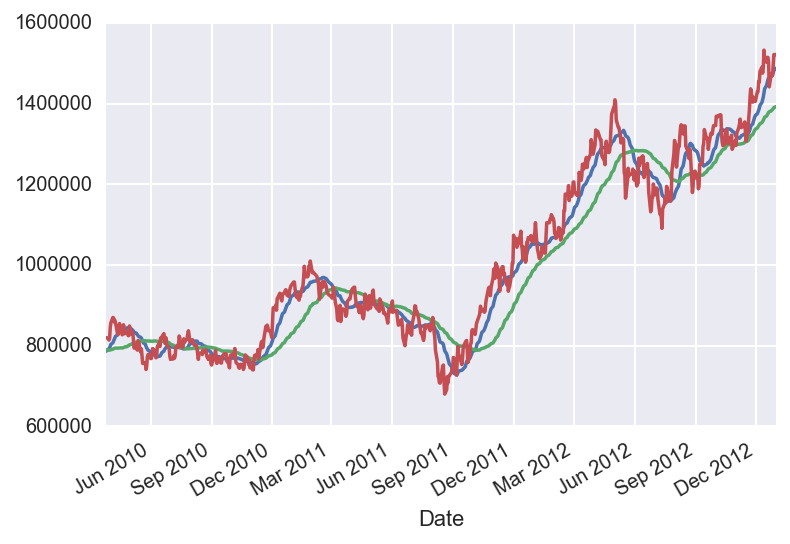

In [13]:
# moving market value
def visualize_moving(date_list, moving_avg_data1, moving_avg_data2, market_value):

    moving1_list = []
    moving2_list = []
    market_value_list = []
    
    for m1 in moving_avg_data1:
        moving1_list.append(m1)

    for m2 in moving_avg_data2:
        moving2_list.append(m2)
        
    for m3 in market_value:
        market_value_list.append(m3)
        
    ts1 = pd.Series(moving1_list, index=date_list)
    plt.figure();
    ts1.plot()

    ts2 = pd.Series(moving2_list, index=date_list)
    ts2.plot()
    
    ts3 = pd.Series(market_value_list, index=date_list)
    ts3.plot()
    
visualize_moving(moving_avg_data1.index, moving_avg_data1, moving_avg_data2, market_value)

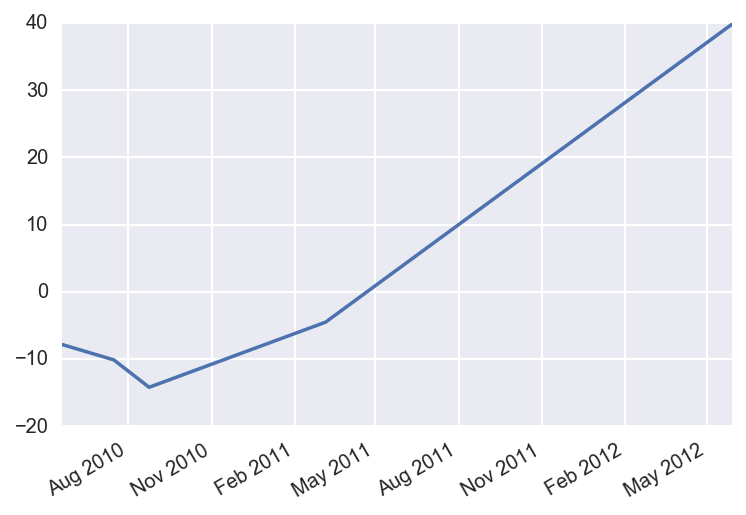

In [14]:
# earning rate
def visualize_earning_rate(golden_cross):
    golden_cross = golden_cross[["date","earning_rate"]][1::2]
    date_list = []
    earning_rate_list = []
    for earning_rate in golden_cross["earning_rate"]:
        earning_rate_list.append(earning_rate)
    for date in golden_cross["date"]:
        date_list.append(date)

    ts = pd.Series(earning_rate_list, index=date_list)
    plt.figure();
    ts.plot()
visualize_earning_rate(golden_cross)

# Find best golden cross line

In [17]:
# final_earning rate
def final_earning_rate(result):
    if len(result) == 0:
        return 0
    else:
        return result.loc[len(result)-1]["earning_rate"]

# find best moving line
def get_max_earning_rate(company_name, moving1, moving2, startdate, enddate):
    
    max_earning_rate = 0
    moving1_const = 0
    moving2_const = 0
        
    for i in range(5, moving1 + 1):
        for j in range(moving1 + 1, moving2 + 1):
            golden_cross, m1, m2, m3 = simulation(company_name, startdate, enddate, i, j, 100000000)
            golden_cross = final_earning_rate(golden_cross)
            if max_earning_rate < golden_cross:
                max_earning_rate = golden_cross
                moving1_const = i
                moving2_const = j
                
    print("moving_line_1 : {0}, moving_line_2 : {1}, max_earning_rate : {2}".format(moving1_const, moving2_const, max_earning_rate))

In [16]:
# find moving line at maximum earning rate ( moving line : 5 to 20 ) 
get_max_earning_rate("삼성전자", 5, 20, "2010-01-01", "2012-12-31")

moving_line_1 : 5, moving_line_2 : 13, max_earning_rate : 25.15893899999999
